# Evaluation Metrics For Regression Models

To be able to measure the performance of a regression model and compare several models, different metrics could use:
    R2 Score, MSE,RMSE,MAE,MAPE

1. Loading the dataset and fitting the model

We will use the Diabetes daa used in the "Least Angle Regression" paper: N=442 patients, p=10 predictors. One row per patient, 
    and the last column is the response variable.

dataset(raw): https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt

In [26]:
pip install -U scikit-learn

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
import time
from pandas.io.json import json_normalize
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,median_absolute_error


In [35]:
df=pd.read_csv('https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt',sep="\t")
print(df.shape)
df.head()

(442, 11)


,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


We will also normalize data, to have the same order of magnitude among the independent variables:

In [43]:
# Scaled data : X-mean: # Start by subtracting the mean with StandardScaler, without dividing by the std(with_std=False)
df_sc=StandardScaler(with_std=False).fit_transform(df)
df_sc=pd.DataFrame(data=df_sc,columns=df.columns)

### Normalize data: divide each feature by its L2 norm
# If axis=0 no need to transpose, this available in normalize method but not in normalizer

df_norm=normalize(df_sc.iloc[:,:-1],norm='l2')

#or transpose the dataframe: (as axis=1 is the default value)
#df_norm=normalize(df_sc.iloc[:,:-1],T,norm='12')
#(not to gorget to transpose the results too, to go back to the initial shape)

df_norm=pd.DataFrame(data=df_norm,columns=df.columns[:-1])
df_norm['Y']=df_sc['Y']
print('Normalized data:Scaled data/L2 norm')
df_norm.head()

Normalized data:Scaled data/L2 norm


,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,0.242521,0.012301,0.132441,0.146990,-0.743632,-0.514549,-0.272751,-0.001625,0.005053,-0.098568,-1.133484
1,-0.015115,-0.013662,-0.139324,-0.223086,-0.179130,-0.357052,0.589631,-0.031222,-0.021868,-0.649396,-77.133484
2,0.493611,0.011176,0.086695,-0.034622,-0.696639,-0.459079,-0.184742,-0.001477,0.000660,-0.131595,-11.133484
3,-0.722696,-0.013804,-0.031710,-0.313832,0.261150,0.470463,-0.288525,0.027405,0.007336,-0.066621,53.866516
4,0.086518,-0.027342,-0.197088,0.370906,0.166959,0.581543,0.129116,-0.004101,-0.020487,-0.657402,-17.133484


1.2 Model to Fit

To illustrate the computation of the the different metrics,step by step, let`s take the predicted values given
by the OLS model'y_predict_ols'.In this example we will not be splitting the dataset to train and test sets.
It`s no the objective of this notebook

In [57]:
features=df.columns[:-1]
X=df_norm[features]
y=df_norm['Y']

### OLS:Orinary Least Square
reg_ols=LinearRegression(fit_intercept=False)
reg_ols.fit(X,y)
#Predict Values
y_predict_ols=reg_ols.predict(X)
df_errors=pd.DataFrame()
df_errors['y_true']=y
df_errors['yhat']=y_predict_ols

df_errors['y_yhat']=df_errors['y_true']-df_errors['yhat']
df_errors['(y_yhat)**2']=df_errors['y_yhat']**2
mean_y=df_errors['y_true'].mean()
df_errors['(y_ymean)**2']=(df_errors['y_true']-mean_y)**2

r2_recomp=1-(np.sum(df_errors['(y_yhat)**2'])/np.sum(df_errors['(y_ymean)**2']))
r2_recomp

0.48233609146755896

SKLEARN 

In [61]:
r2_sk_learn=r2_score(y,y_predict_ols)
r2_sk_learn

0.48233609146755885

Both

In [62]:
print('r2 recomputed:',r2_recomp,'r2_sk_learn',r2_sk_learn)

r2 recomputed: 0.48233609146755896 r2_sk_learn 0.48233609146755885


Let`s Visualize

Text(0.5, 1.0, 'Regression: Predicted vs True')

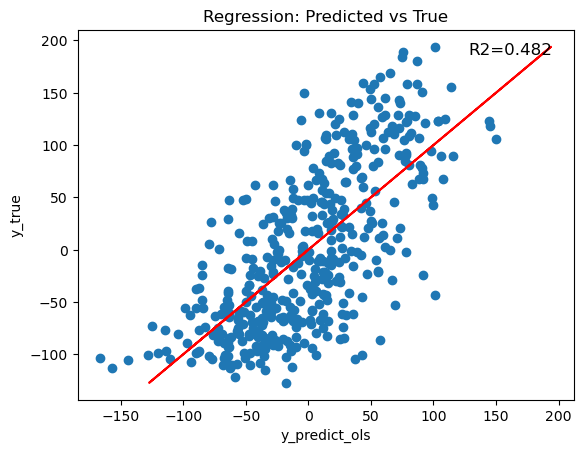

In [63]:
plt.scatter(y_predict_ols,y)
plt.plot(y,y,'-r')
plt.annotate(r"R2={0}".format(round(r2_recomp,3)),xy=(200,200),xytext=(-65,-10),
            textcoords='offset points',fontsize=12)
plt.xlabel('y_predict_ols')
plt.ylabel('y_true')
plt.title('Regression: Predicted vs True')

Explained Variable Score

In [66]:
N=y.shape[0]

df_errors=pd.DataFrame()
df_errors['y_true']=y
df_errors['yhat']=y_predict_ols

mean_y=df_errors['y_true'].mean()
df_errors['(y_ymean)**2']=(df_errors['y_true']-mean_y)**2
var_y=np.sum(df_errors['(y_ymean)**2'])/N
df_errors['y_yhat']=df_errors['y_true']-df_errors['yhat']
mean_yyhat=df_errors['y_yhat'].mean()
df_errors['(y_yhat_yyhatmean)**2']=(df_errors['y_yhat']-mean_yyhat)**2
var_yyhat=np.sum(df_errors['(y_yhat_yyhatmean)**2'])/N

explained_variance_recomp=1-var_yyhat/var_y
explained_variance_recomp

0.4824491425011799

SKLearn

In [70]:
explained_variance_sklearn=explained_variance_score(y,y_predict_ols)
explained_variance_sklearn

0.4824491425011799

Both

In [72]:
print('Explained variance recomputed:',explained_variance_recomp,'Explained variance from sk_learn',explained_variance_sklearn)

Explained variance recomputed: 0.4824491425011799 Explained variance from sk_learn 0.4824491425011799


One can see that the explained variance and the R2 score are equal. That`s because the mean of the residual is ~0

In [73]:
mean_yyhat=df_errors['y_yhat'].mean()
mean_yyhat

0.8187671322471713

MSE : Mean Squared Error

In [74]:
N=y.shape[0]
df_errors=pd.DataFrame()
df_errors['y_true']=y
df_errors['yhat']=y_predict_ols
df_errors['y_yhat']=df_errors['y_true']-df_errors['yhat']
df_errors['(y_yhat)**2']=df_errors['y_yhat']**2
mse_recomp=np.sum(df_errors['(y_yhat)**2'])/N
mse_recomp

3069.6873928821205

SKLearn

In [78]:
mse_sklearn=mean_squared_error(y,y_predict_ols)
mse_sklearn

3069.6873928821205

Both

In [80]:
print('MSE Recomputed:',mse_recomp,'MSE from sk_learn',mse_sklearn)

MSE Recomputed: 3069.6873928821205 MSE from sk_learn 3069.6873928821205


RMSE: Root Mean Squared Error

In [82]:
rmse_recomp=np.sqrt(mse_recomp)
rmse_recomp

55.40475965909536

SK Learn

In [83]:
rmse_sklearn=mean_squared_error(y,y_predict_ols,squared=False)
rmse_sklearn

55.40475965909536

Both

In [84]:
print('RMSE Recomputed:',rmse_recomp,'RMSE from sk_learn:',rmse_sklearn)

RMSE Recomputed: 55.40475965909536 RMSE from sk_learn: 55.40475965909536


MAE : Mean Absolute Error

In [93]:
N=y.shape[0]
df_errors=pd.DataFrame()
df_errors['y_true']=y
df_errors['yhat']=y_predict_ols
df_errors['y_yhat']=df_errors['y_true']-df_errors['yhat']
df_errors['abs(y_yhat)']=df_errors['y_yhat'].abs()
mae_recomp=np.sum(df_errors['abs(y_yhat)'])/N
mae_recomp

45.885213649138834

SK Learn

In [94]:
mae_sklearn=mean_absolute_error(y,y_predict_ols)
mae_sklearn

45.885213649138834

Both

In [92]:
print('MAE recomputed:',mae_recomp,'MAE from sk_learn:',mae_sklearn)

MAE recomputed: 45.885213649138834 MAE from sk_learn: 45.885213649138834


MAPE: Mean Absolute Percentage Error

In [96]:
N=y.shape[0]
epsilon=0.0001
df_errors=pd.DataFrame()
df_errors['y_true']=y
df_errors['yhat']=y_predict_ols
df_errors['y_yhat']=df_errors['y_true']-df_errors['yhat']
df_errors['abs(y_yhat)']=df_errors['y_yhat'].abs()
df_errors['abs(y_true)']=df_errors['y_true'].apply(lambda x:max(epsilon,np.abs(x)))
df_errors['(y_yhat)/y']=df_errors['abs(y_yhat)']/df_errors['abs(y_true)']
mape_recomp=np.sum(df_errors['(y_yhat)/y'])/N
mape_recomp

3.03466206442493

SK Learn

In [98]:
mape_sklearn=mean_absolute_percentage_error(y,y_predict_ols)
mape_sklearn

3.03466206442493

Both

In [99]:
print('MAPE recomputed:',mape_recomp, 'MAPE from sklearn:',mape_sklearn)

MAPE recomputed: 3.03466206442493 MAPE from sklearn: 3.03466206442493


In [101]:
N=y.shape[0]
epsilon=0.0001
df_errors=pd.DataFrame()
df_errors['y_true']=y
df_errors['yhat']=y_predict_ols
df_errors['y_yhat']=df_errors['y_true']-df_errors['yhat']
df_errors['abs(y_yhat)']=df_errors['y_yhat'].abs()

medae_recomp=np.median(df_errors['abs(y_yhat)'])
medae_recomp

42.166118060703866

SK Learn

In [104]:
medae_sklearn=median_absolute_error(y,y_predict_ols)
medae_sklearn

42.166118060703866

Both

In [105]:
print('MEDAE Recomputed:',medae_recomp, 'MEDAE from sklearn', medae_sklearn)

MEDAE Recomputed: 42.166118060703866 MEDAE from sklearn 42.166118060703866


 Evaluation Metrics to compare among models

We will use 2 regression models, to fit the data and evaluate their performance.
As explained at the beginning, we will not be splitting the dataset to train and test sets.
Its not the objective of this notebook.

In [111]:
features=df.columns[:-1]
X=df_norm[features]
y=df_norm['Y']

### OLS: Ordinary Least Square

reg_ols=LinearRegression(fit_intercept=False)
reg_ols.fit(X,y)

## Predict Values
y_predict_ols=reg_ols.predict(X)

## LASSO
reg_lasso=Lasso(alpha=1,fit_intercept=False) # Without cross-validation to find the best alpha, it`s not the objective here
reg_lasso.fit(X,y)
#Predict values
y_predict_lasso=reg_lasso.predict(X)

Now what we fit the models, let`s compute the different metrics for each of them:

In [114]:
predicted_values=[y_predict_ols,y_predict_lasso]
models=['OLS','LASSO']

measures_list=[]

i=0

for y_predict in predicted_values:
    r2=r2_score(y,y_predict)
    explained_variance=explained_variance_score(y,y_predict)
    mse=mean_squared_error(y,y_predict)
    rmse=mean_squared_error(y,y_predict,squared=False)
    mae=mean_absolute_error(y,y_predict)
    mape=mean_absolute_percentage_error(y,y_predict)
    medae=median_absolute_error(y,y_predict)
    measures_list.append([models[i],r2,explained_variance,mse,rmse,mae,mape,medae])
    i=+1
    
    df_results=pd.DataFrame(data=measures_list,
                            columns=['model','r2','explained_var','mse','rmse','mae','mape','medae'])

In [115]:
df_results

,model,r2,explained_var,mse,rmse,mae,mape,medae
0,OLS,0.482336,0.482449,3069.687393,55.40476,45.885214,3.034662,42.166118
1,LASSO,0.428986,0.429100,3386.045847,58.18974,48.293216,3.093502,44.530827


As shown in the results, the R2 is higher for the OLS(0.48) than the Lasso model(0.12)
(even if the value in absolute terms is not that high)

At this stage, we can assume that the OLS is a better model than the Lasso for our dataset

Furthermore, the MSE and RMSE are lower for the OLS than Lasso. Once again, OLS is a good fit for our dataset

MAE and MedAE are also showing better results for OLS than Lasso

However, MAPE is lower for the Lasso than the OLS, showing that there are some values of the true y that could be high, making
the relative value of the residual lower. It could be interesting to study the outliers in the dataset, and remove them if any.

Globally, the OLS model is showin gbetter metrics than the Lasso model. Thus between these 2 models, OLS will be a good fit 
for our Dataset.

I hope you enjoyed it.